# Face Prediction Using Trained Model with Facenet Pytorch

This notebook will showcase the prediction capability of the best model we've trained in the Classifier notebook We've integrated the code in the Detector and Classifier and we will try to predict images we have uploaded under "img/predict" folder and discuss some observations we've noticed.

In [83]:
#Initialize variables
import os
#change this to your username if running on Jojie without admin permisison
os.environ['XDG_CACHE_HOME'] = '/home/msds2023/rbanquerigo/.cache' 

import torch
import torch.nn as nn
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from PIL import Image
from matplotlib.patches import Rectangle    
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


from PIL import Image


In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [87]:
def get_all_pics(path, sample_count):
    """
        This returns all the files within the specified path with .jpg or jpeg 
        file format and checks the length of the fles against the sample_count
        that will be displayed.
        
        path - string, path where the images are located
        sample_count - int, how many samples will be displayed
        
        Return
        f_list - list of images with .jpg file type
        sample_count - int value of the samples
    """
    f_list = []
    for f in  os.listdir(path):
        if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg'):
            f_list.append(f)
    if sample_count > len(f_list):
        sample_count = len(f_list)
        
    return f_list, sample_count


In [106]:
def plot_images(ax, x1, y1, x2, y2, name):
    """
        This plots the faces rectangle patches and sets the name of the
        scanned faces.
        
        ax - axes of the matplotlib 
        x1, y1, x2, y2 - float box coordinates
        name - string classification of the box
    """
    width = x2 - x1
    height = y2 - y1
    font_size = min(height, width) // 20
    if font_size > 20:
        font_size = 20
    elif font_size < 8:
        font_size = 8
    ax.text(0.5*(x1+x2), .98*y2, name,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=font_size, color='red')

    rec = Rectangle((x1, y1), width, 
                    height, 
                    fill=False, 
                    ec='tab:green',
                    linewidth=3)
    
    ax.add_patch(rec) 



In [107]:
#Set the classes and transformation for the image input 
classes = ['bj', 'greg', 'loraine', 'rozz']
mean_std = np.load('mean_std.npz') #Load the mean and standard deviation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_std['means'], std=mean_std['stds'])
])

Similar to the last set of code in the Classifier notebook we will be loading the best model into the architecture we've trained on.

In [108]:

best_model_path = 'best_model.pth'
load_model = (InceptionResnetV1(pretrained='vggface2', 
                          classify=True, 
                          num_classes=4))
load_model.logits = nn.Sequential(nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(256, 4, bias=True))

load_model.load_state_dict(torch.load(best_model_path, map_location=device.type))
load_model.to(device);

In [114]:
def predict_face(img, model, pct):
    """
        Function will feed the image into the mode to predict the faces
        and returns the classifcation if it meets the threshold we set.
        Softmax will calculate from the logits and returns the highest 
        predicted class.
        
        img - PIL Image to detect the faces
        model - model for predicting faces
        pct - threshold for the similarity prediction
    """
    
    #Set to eval to not update the gradients
    model.eval()
    image = transform(img).unsqueeze(0)
    
    #Ensure image is also loaded into the GPU
    if device.type == 'cuda': 
        image = image.cuda()
        
    #Predict the faces
    with torch.no_grad():
        output = model(image)
        
    #used softmax on the logits and check if % is higher than threshold 
    if torch.softmax(output, dim=1)[0].cpu().numpy().max() >= pct:
        prediction = output.argmax(dim=1).item()
        return classes[prediction]
       
    else:
        return 'Unknown' #Name will be set to Unknown if below threshold

In [110]:
def detect_faces(path, detect_model, pred_model, pct_det, pct_class, sample_count):
    """
        This function will detect and classify all the faces that meets
        the set thresholds. Will display the random set of images based on
        the sample count.
        
        path - string, path where the images are located
        save - string, path where the cropped faces will be saved
        detect_model - model object for the face detectiion
        pred_model - model object for face classification
        pct_det - float, threshold on the face detection
        pct_class - float
        sample_count - int, how many samples will be displayed
    """
    
    #Get all the files using get_all_pics
    files, sample_count = get_all_pics(path, sample_count)

    #Randomized which photos will be displayed
    rand = random.sample(range(0, len(files)), sample_count)

    #Initialize number of subplots for the main image
    fig, ax = plt.subplots(sample_count, 1, figsize=(20, 20))

    #loop to process the images found in the path
    for idx, file in enumerate(files):

        #Open the image using PIL Image
        img = Image.open(os.path.join(path, file)).convert('RGB')

        #Detect faces using the MTCNN model with img as its input
        boxes, pred = detect_model.detect(img)


        #Skips to the next image if no face was found
        if boxes is None:
            continue

        #Check if index of current image is the one to be sampled 
        try:
            ind = rand.index(idx)
        except ValueError:
            continue

        #Gets the axes for plotting the image
        ax_main = ax[ind] if sample_count > 1 else ax

        #Loop through all the detected image
        for cnt, box in enumerate(zip(boxes, pred)):
            if box[1] >= pct_det:

                #Crop the faces to be predicted
                x1, y1, x2, y2 = box[0]
                cropped_image = img.crop((x1, y1, x2, y2))
                pred_name = predict_face(cropped_image, 
                                         pred_model, 
                                         pct_class)

                #Plot the faces with the predicted name
                plot_images(ax_main, x1, y1, x2, y2, pred_name)

        ax_main.title.set_text(file)
        ax_main.imshow(img)
        ax_main.axis('off')

    plt.show()


In the Detector and Classifier notebook, we load the best-trained model with the architecture we trained (InceptionResnetV1 model with VGGFace2 weights) and initialize the MTCNN (Multi-task Cascaded Convolutional Networks) as our face detector.

The code allows us to adjust the threshold classification percentage. In this case, we have set it to a minimum accuracy of 60% for the highest prediction in classification and a detection threshold of 80%, similar to what we used in the Detector notebook. If you wish to have more images available for prediction, you can upload them to the "img/predict" directory. However, for discussion purposes, we have provided five example images.

Let's analyze the results for each image:

    1. The (FINALTEST001_) image successfully detects BJ and Loraine, as they have higher pixel resolution, while Greg's angle and facial expression are not present in the training set. Similarly, my sideways pose doesn't have a corresponding image in the training set, resulting in a lower prediction for me. MTCNN also detects a patch and Starbucks image in the photo.

    2. The (FINALTEST005_) image is flipped, but since the training data includes facial expressions of myself, Loraine, and Greg, and augmentation techniques involve randomized flipping, the model is still able to detect us correctly in this flipped photo.

    3. In images (FINALTEST006_ and (FINALTEST007_), the model correctly detects and classifies all of us. This was expected as the training set includes similar pictures with varying zoom ratios. Additionally, the model also classifies the people in the background, which is similar to me, and one person with Greg. This is due to the presence of low-resolution faces in my training data and Greg's training data containing images with different lighting and color, which resulted in more generalized predictions.

    4. In the photo (FINALTEST002_) with Prof Chris, the model successfully detects myself, Greg, and Loraine, but BJ is not detected. Upon reviewing the training set, we found that BJ does not have a picture facing upfront, smiling, and wearing glasses similar to that image. Furthermore, the high brightness of the photo poses an additional challenge. Even when lowering the threshold to 40%, the model still fails to classify BJ correctly, while mistakenly tagging Prof Chris as BJ.

These observations highlight the strengths and limitations of the trained model, including the impact of training data variations, facial expressions, angles, and lighting conditions.

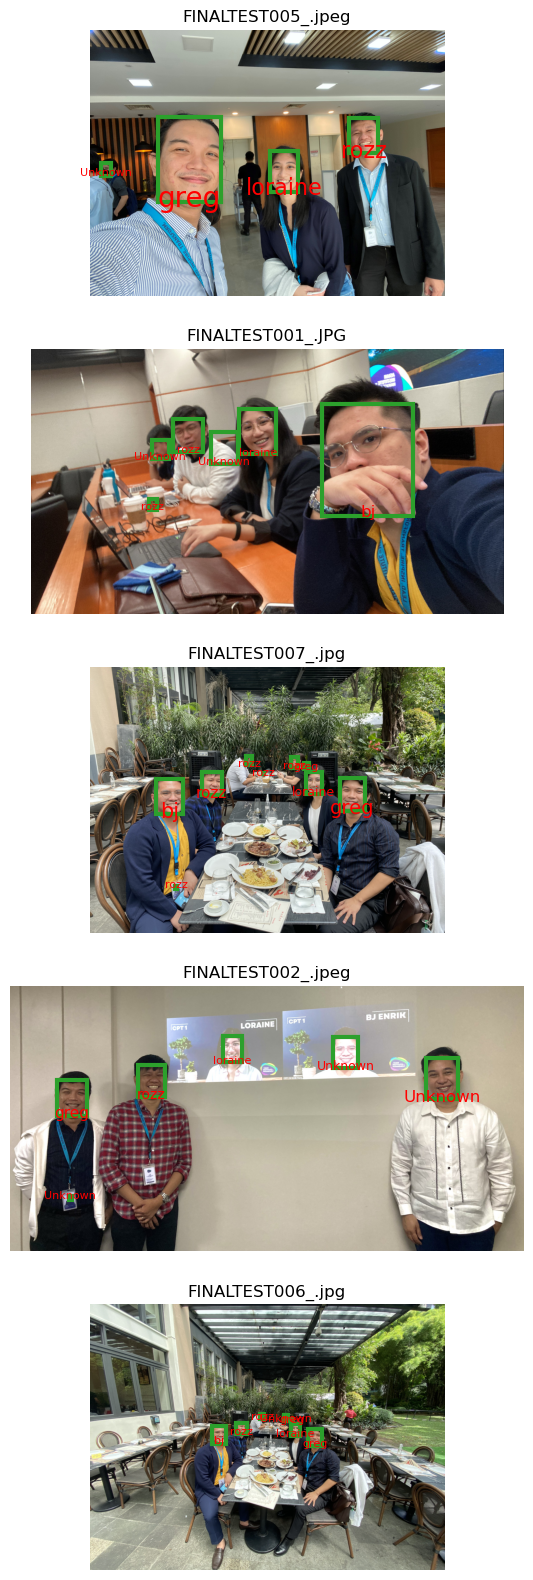

In [118]:
#Path for prediction
path = 'img/predict'

#File of the saved best model
best_model_path = 'best_model.pth'

#Initialize pretrained models
mtcnn_model = MTCNN(device=device)
vgg_model = (InceptionResnetV1(pretrained='vggface2', 
                          classify=True, 
                          num_classes=4))
vgg_model.logits = nn.Sequential(nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(256, 4, bias=True))
vgg_model.load_state_dict(torch.load(best_model_path, map_location=device.type))
vgg_model.to(device)

#Set init variables
threshold_detect = .80
threshold_classify = .60
sample_count = 5

detect_faces(path, mtcnn_model, vgg_model, threshold_detect, threshold_classify, sample_count)

### Conclusion

Based on the results of the predictions, it is clear that there is room for improvement in training the model to better handle variations in zoom, aspect ratios, lighting, face angles, accesories, hairstyle, and facial expressions. While Data Augmentation can provide some assistance, obtaining more data would be beneficial. Increasing the dataset size allows the model to learn from a wider range of examples and improve its ability to accurately classify individuals under different conditions. We can also consider optimizing other parameters used in the convolutional layer such as kernel size, padding, dilation, and stride as we were not able to apply it here since we have a ready built architure being used.

In my opinion, when dealing with models aimed at identifying specific individuals within a set of photos, it is preferable to lean towards overfitting. This means training the model to perform exceptionally well on the given dataset, even if it might not generalize as effectively to unseen data. Overfitting can be advantageous in scenarios where the primary objective is to accurately identify a particular person rather than achieving overall generalization.

It's worth noting that the current analysis is based on a single model, and there are possibilities of exploring and evaluating other models that may perform better. Additionally, the refinement of hyperparameters plays a crucial role in improving the model's performance. With numerous options available for testing and experimentation, it can be overwhelming. However, as you progress through the program and gain experience, you'll be better equipped to tackle real-world problems and make informed decisions regarding model selection and optimization.

Credits to ChatGPT for helping me on the writeups, however for the code this is purely from experience, class notebooks, stackoverflow, and Github: https://github.com/timesler/facenet-pytorch of facenet_pytorch.